In [1]:
import pandas as pd

Here we import text and label data by passing file paths into the pandas read_csv function. This data can be downloaded from: https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences. 

In [2]:
amazon, imdb, yelp = [pd.read_csv('labeled_sent_data/'+str(i)+'.txt', sep="\t", header=None) 
                      for i in ['amazon','imdb','yelp']]

In [3]:
amazon

,0,1
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,The screen does get smudged easily because it ...,0
996,What a piece of junk.. I lose more calls on th...,0
997,Item Does Not Match Picture.,0
998,The only thing that disappoint me is the infra...,0


We can then combine our three data sources since we are not interested in comparing the separate datasets to each other in this notebook.

In [4]:
sumData = pd.concat([amazon,imdb,yelp])
sumData.columns = ['text','label']
sumData

,text,label
0,So there is no way for me to plug it in here i...,0
1,"Good case, Excellent value.",1
2,Great for the jawbone.,1
3,Tied to charger for conversations lasting more...,0
4,The mic is great.,1
...,...,...
995,I think food should have flavor and texture an...,0
996,Appetite instantly gone.,0
997,Overall I was not impressed and would not go b...,0
998,"The whole experience was underwhelming, and I ...",0


We then want to clean the text data to be lowercase, without punctuation, and without braces or numbers, generally this information does not contribute to analysis although it may be in more complicated text analysis methods. We can clean our data using `Regular Expressions` which are character mappings for finding patterns in text, we also import `string` which is a native python library with a set of string types.

In [5]:
import re
import string

In [6]:
def cleanText(text):
    text=text.lower()
    # regex
    text = re.sub('\[.*?\]', '', text) # remove text in brackets
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) # remove punctuation
    text = re.sub('\w*\d\w*', '', text) # remove words with numbers in them
    return text

cleaningRound = lambda x: cleanText(x)

Pandas includes functionality to map data through a function.

In [7]:
cleanedData = pd.DataFrame(sumData.text.apply(cleaningRound))

In [8]:
sumData.text = cleanedData # We replace the text column with our cleaned text data column.
sumData

,text,label
0,so there is no way for me to plug it in here i...,0
1,good case excellent value,1
2,great for the jawbone,1
3,tied to charger for conversations lasting more...,0
4,the mic is great,1
...,...,...
995,i think food should have flavor and texture an...,0
996,appetite instantly gone,0
997,overall i was not impressed and would not go back,0
998,the whole experience was underwhelming and i t...,0


Before performing any kind of training or analysis on our data, we want to partition a segment of it to test our trained model on, so we split our data into training and testing, and ensure that this partition select uniformally and randomly throughout our entire dataset. `sklearn` provides a function that handles this. 

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
train,test = train_test_split(sumData, test_size=.2)
train

,text,label
919,what should have been a hilarious yummy christ...,0
875,this is by far the worst purchase ive made on ...,0
348,the bipolarity of the ruthless thug one minute...,0
961,if someone orders two tacos dont you think it ...,0
611,i checked out this place a couple years ago an...,0
...,...,...
535,all it took was one drop from about inches ab...,0
614,when achille and philippa beautifully sing a d...,1
925,motorola finally got the voice quality of a bl...,1
415,i have used several phone in two years but thi...,1


In [11]:
test

,text,label
472,disappointment i hate anything that goes in my...,0
824,awkward to use and unreliable,0
496,you wont regret it,1
608,it is cheap and it feel and look just as cheap,0
263,absolutel junk,0
...,...,...
805,i had high hopes for this place since the burg...,0
401,overall i was very disappointed with the quali...,0
981,we started with the tuna sashimi which was bro...,0
777,worthwhile,1


We are now looking for a way to interpret our text data numerically, which will let us build a model to differentiate between all phrases.

The method used below builds a dictionary of unique words used in the entire dataset, sets each word as a column of a matrix, and then represents each phrase in the dataset as a row where cell values start at zero and increment for each vocabulary used throughout the columns -- essentially providing a frequency table of words for every phrase.

`sklearn` provides a `vectorizer` that handles this, and additionally removes conjunctions like `a, the, and` which similar to our cleaning step above, removes data that does not contribute to this analysis. One step more complicated that isn't done below, is to increment counts for excessively frequent words or weigh words with excessive counts less heavily. A dataset on film or food for instance might use the words 'film' and 'food' conjunctively. 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
TrainVectorizer = CountVectorizer()
fittedTrainVectors = TrainVectorizer.fit_transform(train.text).todense()
fittedTrainVectors

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

The above builds our vectors and dictionary. To create the vectors of our test dataset we don't want to include any more vocabulary and in fact want to use the exact same vocabulary that was built during our training. So we can pass the vocabulary found during the vectorizing step above to produce our testing vectors. 

In [14]:
TrainVectorizer.get_feature_names()[:10]

['aailiyah',
 'abandoned',
 'abhor',
 'ability',
 'able',
 'abound',
 'about',
 'above',
 'abroad',
 'absolutely']

In [15]:
# Notice the train vocabulary being passed in.
TestVectorizer = CountVectorizer(vocabulary = TrainVectorizer.get_feature_names()) 
fittedTestVectors = TestVectorizer.transform(test.text).todense()
fittedTestVectors

matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

We are now interested in classifying our vectors. One way to intuit this step is in the 2d linear regression example, where given points of two colors, scattered on an x,y plane, we are interested in finding a line of the form $y=mx+b$ that best segregates the points by finding the best parameters for $m$ and $b$. In this example though, we are building a polynomial line and have an n-dimensional space that correlates to how many vocabulary words, also known as features, were found in the vectorizing step. `sklearn` has a logistic regression model that can handle this for us.

In [16]:
from sklearn.linear_model import LogisticRegression

In [17]:
def sentClassifier(trainData, trainLabel, testData, testLabel):
    classification = LogisticRegression().fit(trainData, trainLabel)
    classificationScore = classification.score(testData, testLabel)
    return classification,classificationScore

In [18]:
classifications = sentClassifier(fittedTrainVectors, train['label'].ravel(),
                                 fittedTestVectors, test['label'].ravel())

In [19]:
classifications

(LogisticRegression(), 0.8036363636363636)

We now have a trained model and an accuracy score for our model build by comparing the predicted classification with the actual label. 

In [20]:
import numpy as np
results = classifications[0].predict(fittedTestVectors) == test['label'].ravel()
np.unique(results, return_counts=True)
439/550

0.7981818181818182

We can also see all the instances wherein it failed.

In [21]:
fails = [[i,j] for i,j in enumerate(results) if j == False]
fails[:10]

[[2, False],
 [12, False],
 [43, False],
 [47, False],
 [48, False],
 [57, False],
 [58, False],
 [59, False],
 [60, False],
 [68, False]]

In [22]:
test['text'].iloc[41]

'if you act in such a film you should be glad that youre gonna drift away from earth as far as possible  '

At this stage the best course of increased accuracy is to weigh words more heavily based on their context. The typical failure will be due to the nature of simply looking at each individual word and seeing if it was in a negatively or positively labeled sentence, regardless of the context. 

We can also see how certain the model was.

In [23]:
certainties = classifications[0].predict_proba(fittedTestVectors)
certainties[41]

array([0.56236905, 0.43763095])

Presumeably, the above sentence does not mention the words "good" or "bad" or any clear polarizer along those lines, so the model was fairly ambiguous about it's sentiment. 

We can also build Bag of Words and Logistic Regression from scratch rather than use `sklearn` for these. 

In [24]:
bagOfWords = pd.DataFrame(fittedTrainVectors)
bagOfWords.columns = TrainVectorizer.get_feature_names()
bagOfWords

,aailiyah,abandoned,abhor,ability,able,abound,about,above,abroad,absolutely,...,youthful,youtube,youve,yucky,yummy,yun,zero,zillion,zombie,zombiestudents
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2193,0,0,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2194,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2196,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can look at an individual phrase and see how it was vectorized.

In [25]:
train['text'].iloc[2]

'the bipolarity of the ruthless thug one minute a ruthless killer the next minute a luvs diaper commercial is completely unconvincing  '

In [26]:
[[ind,i] for ind,i in enumerate(bagOfWords.iloc[2]) if i>0]

[[377, 1],
 [774, 1],
 [793, 1],
 [1090, 1],
 [2144, 1],
 [2232, 1],
 [2418, 1],
 [2573, 2],
 [2711, 1],
 [2777, 1],
 [2799, 1],
 [3443, 2],
 [4090, 3],
 [4146, 1],
 [4308, 1]]

In [27]:
bagOfWords.columns[[ind for ind,i in enumerate(bagOfWords.iloc[2]) if i>0]]

Index(['bipolarity', 'commercial', 'completely', 'diaper', 'is', 'killer',
       'luvs', 'minute', 'next', 'of', 'one', 'ruthless', 'the', 'thug',
       'unconvincing'],
      dtype='object')

The following is code for building logistic regression.

In [28]:
# Gradient descent to optimize function
# Could do at least one whole session on this, if not several
def gradient_descent(X, y, params, learning_rate, iterations):
    m = len(y)
    cost_history = np.zeros((iterations,1))

    for i in range(iterations):
        params = params - (learning_rate/m) * (X.T @ (sigmoid(X @ params) - y)) 
        cost_history[i] = compute_cost(X, y, params)

    return (cost_history, params)
# Logistic regression cost function
def compute_cost(X,y,theta):
    m = len(y)
    h = sigmoid(X@ theta)
    epsilon = 1e-5
    cost = (1/m)*(((-y).T @ np.log(h + epsilon))-((1-y).T @ np.log(1-h + epsilon)))
    return cost
# https://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html#cost-function
# Sigmoid activation function
def sigmoid(x):
    return 1/(1+np.exp(-x))
# https://mathworld.wolfram.com/SigmoidFunction.html
def predict(X, params):
    return np.round(sigmoid(X @ params))

We now want to find parameters for a best fit classifier "line" that can segregate positive and negative labels well.

In [29]:
y = np.vstack(train['label'].ravel())
X = fittedTrainVectors
m = len(y)
X = np.hstack((np.ones((m,1)),X))
n = np.size(X,1)
params = np.zeros((n,1))

In [30]:
np.shape(params)

(4700, 1)

In [31]:
iterations = 1000
learning_rate = 0.3
initial_cost = compute_cost(X, y, params)
(cost_history, fittedParams) = gradient_descent(X, y, params, learning_rate, iterations)

print(fittedParams, "\n")

[[-0.08531973]
 [ 0.02823954]
 [-0.05334732]
 ...
 [-0.05363031]
 [ 0.00995256]
 [-0.04014604]] 



In [32]:
np.shape(fittedParams)

(4700, 1)

We can visualize the optimization process using matplotlib as the cost history saved above.

In [33]:
import matplotlib.pyplot as plt

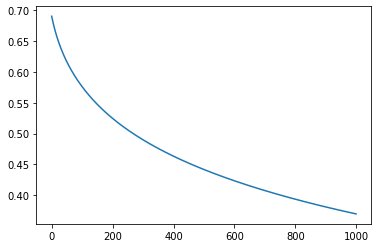

In [34]:
plt.plot(range(len(cost_history)), cost_history)

As the number of iterations increases, the logistic nature of the graph above will get more and more pronounced. 

We can also see how well the above model performed.

In [35]:
y_pred = predict(X, fittedParams)
score = float(sum(y_pred == y))/ float(len(y))

print(score)

0.9008189262966333


As well as the certainty scores. 

In [36]:
unrounded = sigmoid(X @ fittedParams)
unrounded[:5]

matrix([[0.31352975],
        [0.20239158],
        [0.2915797 ],
        [0.11945554],
        [0.2764864 ]])

In [37]:
train['label'][:5]

919    0
875    0
348    0
961    0
611    0
Name: label, dtype: int64

The following is a repeated walk through of the vectorizing process, now with a single phrase. 

In [38]:
singleTest = [test['text'].iloc[0]]
singleTest

['disappointment i hate anything that goes in my ear']

In [39]:
vocab = np.vstack([[ind,val] for ind,val in enumerate(bagOfWords.columns)])
vocab

array([['0', 'aailiyah'],
       ['1', 'abandoned'],
       ['2', 'abhor'],
       ...,
       ['4696', 'zillion'],
       ['4697', 'zombie'],
       ['4698', 'zombiestudents']], dtype='<U33')

In [40]:
singleTestIndices = [i for i in vocab for j in singleTest[0].split() if i[1] == j]
singleTestIndices

[array(['170', 'anything'], dtype='<U33'),
 array(['1119', 'disappointment'], dtype='<U33'),
 array(['1242', 'ear'], dtype='<U33'),
 array(['1752', 'goes'], dtype='<U33'),
 array(['1858', 'hate'], dtype='<U33'),
 array(['2047', 'in'], dtype='<U33'),
 array(['2664', 'my'], dtype='<U33'),
 array(['4087', 'that'], dtype='<U33')]

In [41]:
initDict = dict(zip(vocab[:,1],np.zeros(len(bagOfWords.columns))))
list(initDict.items())[:5]

[('aailiyah', 0.0),
 ('abandoned', 0.0),
 ('abhor', 0.0),
 ('ability', 0.0),
 ('able', 0.0)]

This is the frequency counting step:

In [42]:
for i in singleTestIndices:
    initDict[i[1]] += 1

In [43]:
initDict['interesting'],initDict['bad'], initDict['overall']

(0.0, 0.0, 0.0)

In [45]:
sigmoid(pd.DataFrame.from_dict(initDict, orient='index').T@fittedParams[:len(fittedParams)-1]).iloc[0][0]

0.38295659693841266

In [46]:
classifications[0].predict(fittedTestVectors)[0]

0

We can then condense the above to apply to any arbitrary phrase.

In [47]:
def classifySingle(text):
    vocab = np.vstack([[ind,val] for ind,val in enumerate(bagOfWords.columns)])
    singleTestIndices = [i for i in vocab for j in text[0].split() if i[1] == j]
    initDict = dict(zip(vocab[:,1],np.zeros(len(bagOfWords.columns))))
    for i in singleTestIndices:
        initDict[i[1]] += 1
    result = sigmoid(pd.DataFrame.from_dict(initDict, orient='index').T@fittedParams[:len(fittedParams)-1])
    if result.iloc[0][0] >= .5:
        return text[0], "Positive Sentiment: %1.2f%%" % (result.iloc[0][0]*100)
    else:
        return text[0], "Negative Sentiment: %1.2f%%" % (result.iloc[0][0]*100)

In [48]:
singleTest = ['once there was a lovely little trashcan watching a big movie']
singleTest

['once there was a lovely little trashcan watching a big movie']

In [49]:
classifySingle(singleTest)

('once there was a lovely little trashcan watching a big movie',
 'Positive Sentiment: 63.31%')

In [50]:
classifySingle(['I absolutely loved watching this movie'])

('I absolutely loved watching this movie', 'Positive Sentiment: 74.35%')

In [51]:
classifySingle(['computers bad rainbows good'])

('computers bad rainbows good', 'Positive Sentiment: 54.85%')

In [52]:
classifySingle(['ugly bad rainbows dog'])

('ugly bad rainbows dog', 'Negative Sentiment: 42.66%')